This notebook demonstrates a complete RAG (Retrieval-Augmented Generation) pipeline
built on my Master's thesis. It shows:
1. Document processing and chunking strategies
2. Embedding and vector store creation
3. Retrieval optimization
4. QA system implementation
5. Evaluation and metrics

### SETUP & CONFIGURATION

In [3]:
import os
import json
import re
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# LangChain components
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings


/Users/tasnimzahan/Documents/LLM engineering projects/ScholarRAG/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tasnimzahan/Documents/LLM engineering projects/ScholarRAG/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1 Configuration

In [1]:
# Configuration
class Config:
    """Central configuration for the RAG pipeline"""
    
    # Paths
    PDF_PATH = "my_thesis.pdf"
    VECTOR_DB_PATH = "./scholar_vectordb"
    RESULTS_PATH = "./results"
    
    # OpenAI

    #OPENAI_API_KEY = "your-api-key-here" 
    EMBEDDING_MODEL = "text-embedding-3-small"
    LLM_MODEL = "gpt-4o-mini"
    
    # Chunking parameters
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200
    
    # Retrieval parameters
    TOP_K = 5
    SEARCH_TYPE = "similarity"  # or "mmr"
    
    # Thesis metadata
    THESIS_TITLE = "Personalized Summarization of Global News: Managing Bias with Large Language Models"
    AUTHOR = "Tasnim Zahan"


In [3]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
   

In [6]:
# Create results directory
Path(Config.RESULTS_PATH).mkdir(exist_ok=True)

print(f" Configuration set")
print(f" PDF: {Config.PDF_PATH}")
print(f" Vector DB: {Config.VECTOR_DB_PATH}")

 Configuration set
 PDF: my_thesis.pdf
 Vector DB: ./scholar_vectordb


# Section 2: DOCUMENT PROCESSING & EXPLORATION
### 2.1 Load and Explore PDF

In [7]:
# Load PDF
loader = PyMuPDFLoader(Config.PDF_PATH)
raw_documents = loader.load()

print(f" Loaded thesis with {len(raw_documents)} pages")
print(f"   First page preview (200 chars):")
print(f"   {raw_documents[0].page_content[:200]}...")

 Loaded thesis with 77 pages
   First page preview (200 chars):
   Tasnim Zahan
Personalized Summarization of Global News: Managing
Bias with Large Language Models
Master’s Thesis in Information Technology
May 25, 2025
University of Jyväskylä
Faculty of Information T...


### 2.2 Analyze Document Structure

In [9]:

def analyze_document_structure(documents: List[Document]) -> pd.DataFrame:
    """Analyze the structure of loaded documents"""
    
    data = []
    for i, doc in enumerate(documents):
        data.append({
            'page': i + 1,
            'characters': len(doc.page_content),
            'words': len(doc.page_content.split()),
            'lines': len(doc.page_content.split('\n')),
        })
    
    return pd.DataFrame(data)

In [10]:
doc_stats = analyze_document_structure(raw_documents)

print("\nDocument Statistics:")
print(doc_stats.describe())


Document Statistics:
            page   characters       words       lines
count  77.000000    77.000000   77.000000   77.000000
mean   39.000000  1658.766234  210.194805   28.753247
std    22.371857   681.021039   79.866342   14.856468
min     1.000000     2.000000    1.000000    1.000000
25%    20.000000  1322.000000  174.000000   25.000000
50%    39.000000  1796.000000  234.000000   28.000000
75%    58.000000  2094.000000  265.000000   30.000000
max    77.000000  3500.000000  336.000000  103.000000


   Saved visualization to ./results/page_analysis.png


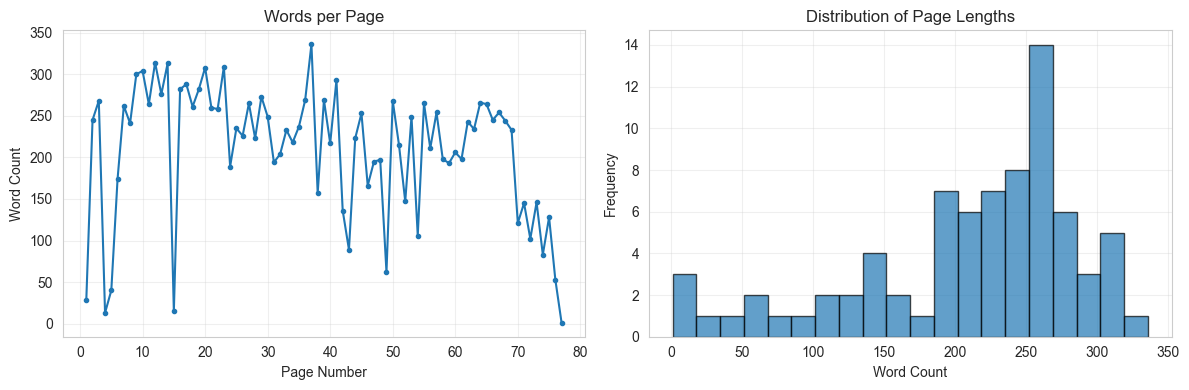

In [8]:
# Visualize page lengths
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(doc_stats['page'], doc_stats['words'], marker='o', markersize=3)
plt.xlabel('Page Number')
plt.ylabel('Word Count')
plt.title('Words per Page')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(doc_stats['words'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Page Lengths')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.RESULTS_PATH}/page_analysis.png', dpi=150, bbox_inches='tight')
print(f"   Saved visualization to {Config.RESULTS_PATH}/page_analysis.png")


### 2.3 Section Detection

In [9]:
class SectionDetector:
    """Detect thesis sections from content"""
    
    SECTION_PATTERNS = {
        #'abstract': r'(?i)^(abstract|abstract:)',
        'abstract': r'(?i)^\s*abstract\s*$',  # Allow leading/trailing whitespace
    
        'intro': r'(?i)^(chapter\s+)?1\.?\s+(introduction|background)',
        'related_work': r'(?i)^(chapter\s+)?2\.?\s+(related\s+work|literature)',
        'methodology': r'(?i)^(chapter\s+)?3\.?\s+(method|approach|design)',
        'results': r'(?i)^(chapter\s+)?4\.?\s+(result|experiment|evaluation)',
        'discussion': r'(?i)^(chapter\s+)?5\.?\s+(discussion|analysis)',
        'conclusion': r'(?i)^(chapter\s+)?6\.?\s+(conclusion|future)',
        'references': r'(?i)^(references|bibliography)\s*$'
    }
    
    @classmethod
    def detect_section(cls, pre_section: str, text: str) -> str:
        """Detect section type from text"""
        header = text[:200].strip()
        #print(header)
        
        for section_type, pattern in cls.SECTION_PATTERNS.items():
            #print(pattern)
            if re.search(pattern, header):
                return section_type
        
        #return 'general'
        return pre_section
    
    
    @classmethod
    def analyze_sections(cls, documents: List[Document]) -> pd.DataFrame:
        """Analyze section distribution"""
        
        section_type = 'general'
        sections = []
        for i, doc in enumerate(documents):
            section_type = cls.detect_section(section_type, doc.page_content)
    
            sections.append({
                'page': i + 1,
                'section_type': section_type,
                'word_count': len(doc.page_content.split())
            })
        
        return pd.DataFrame(sections)

In [10]:
section_df = SectionDetector.analyze_sections(raw_documents)

In [11]:

print("\n Section Distribution:")
print(section_df['section_type'].value_counts())
print(section_df['section_type'])


 Section Distribution:
section_type
methodology     17
conclusion      17
related_work    11
results         11
general          8
intro            7
discussion       6
Name: count, dtype: int64
0        general
1        general
2        general
3        general
4        general
         ...    
72    conclusion
73    conclusion
74    conclusion
75    conclusion
76    conclusion
Name: section_type, Length: 77, dtype: object


   Saved to ./results/section_distribution.png


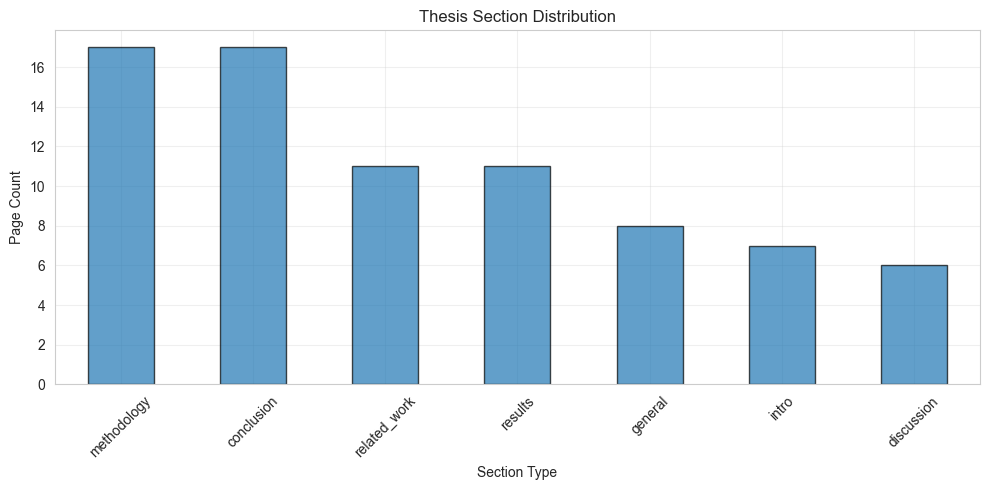

In [12]:
# Visualize sections
section_counts = section_df['section_type'].value_counts()
plt.figure(figsize=(10, 5))
section_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Section Type')
plt.ylabel('Page Count')
plt.title('Thesis Section Distribution')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{Config.RESULTS_PATH}/section_distribution.png', dpi=150, bbox_inches='tight')
print(f"   Saved to {Config.RESULTS_PATH}/section_distribution.png")

# SECTION 3: CHUNKING STRATEGY EXPERIMENTATION
### Chunk size: 1000 chars, Overlap: 200 chars


In [13]:
# Document chunking
def doc_chunking(documents: List[Document], 
                          chunk_size: int, 
                          chunk_overlap: int) -> List[Document]:
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    
    chunks = text_splitter.split_documents(documents)
    
    # Add metadata
    section_type = 'general'
    for chunk in chunks:
        section_type = SectionDetector.detect_section(section_type, chunk.page_content)
        chunk.metadata['section_type'] = section_type
        chunk.metadata['word_count'] = len(chunk.page_content.split())
        #print(chunk.metadata['section_type'])
    
    return chunks

In [14]:
CHUNKS = doc_chunking(
    raw_documents,
    Config.CHUNK_SIZE,
    Config.CHUNK_OVERLAP
)

print(f"\n Selected chunking strategy:")
print(f"   Chunk size: {Config.CHUNK_SIZE}")
print(f"   Overlap: {Config.CHUNK_OVERLAP}")
print(f"   Total chunks: {len(CHUNKS)}")



 Selected chunking strategy:
   Chunk size: 1000
   Overlap: 200
   Total chunks: 186


In [15]:
# Show sample chunk
print(f"\n Sample Chunk:")
sample = CHUNKS[120]
print(f"   Page: {sample.metadata.get('page', 'N/A')}")
print(f"   Section: {sample.metadata.get('section_type', 'N/A')}")
print(f"   Words: {sample.metadata.get('word_count', 'N/A')}")
print(f"   Preview: {sample.page_content[:300]}...")


 Sample Chunk:
   Page: 46
   Section: results
   Words: 123
   Preview: minimal variation across different personalization configurations, indicating that the factual
integrity of summaries was preserved regardless of whether the output was generic, attribute-
guided, or prompt-based.
This finding suggests that the integration of user preferences—such as reading level, ...


# SECTION 4: EMBEDDING & VECTOR STORE

### 4.1 Create embeddings

In [16]:
import shutil

# First, completely remove the existing database directory
db_name = Config.VECTOR_DB_PATH # Replace with your actual db_name
if os.path.exists(db_name):
    shutil.rmtree(db_name)
    print(f"Removed existing database directory: {db_name}")

In [ ]:
# Initialize embeddings
#from langchain.embeddings import HuggingFaceEmbeddings
#embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")

# OpenAIEmbeddings (cost included)
embeddings = OpenAIEmbeddings(model=Config.EMBEDDING_MODEL)

# Delete if already exists
db_name = Config.VECTOR_DB_PATH
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore
vectorstore = Chroma.from_documents(
    documents=CHUNKS, 
    embedding=embeddings, 
    persist_directory=db_name,
    #collection_name="thesis_collection"
)

print(f"Vectorstore created with {vectorstore._collection.count()} documents")
print(f"   Persisted to: {Config.VECTOR_DB_PATH}")

Vectorstore created with 186 documents
   Persisted to: ./scholar_vectordb


### 4.2 Test Similarity Search

In [ ]:
def test_retrieval(query: str, k: int = 3):
    """Test similarity search"""
    
    results = vectorstore.similarity_search(query, k=k)
    
    print(f"\n Query: '{query}'")
    print(f"   Retrieved {len(results)} chunks:\n")
    
    for i, doc in enumerate(results):
        print(f"   [{i+1}] Page {doc.metadata.get('page', '?')} "
              f"({doc.metadata.get('section_type', 'general')})")
        print(f"       {doc.page_content[:150]}...\n")
    
    return results

In [ ]:
# Test queries
test_queries = [
    "What methodology was used?",
    "bias detection",
    "evaluation metrics"
]

print("\n Testing Retrieval Quality:")
for query in test_queries:
    test_retrieval(query, k=2)


🧪 Testing Retrieval Quality:

🔍 Query: 'What methodology was used?'
   Retrieved 2 chunks:

   [1] Page 26 (methodology)
       pathway for analysis and interpretation in subsequent sections.
3.1
Research Design
This study utilizes a mixed-methods research approach that integra...

   [2] Page 40 (methodology)
       To address these methodological limitations, the study implemented several quality control
mechanisms. Prompt templates were designed with minimal var...


🔍 Query: 'bias detection'
   Retrieved 2 chunks:

   [1] Page 17 (related_work)
       maries and their source documents. While effective at spotting hallucinations, these tools are
limited in detecting subtle bias manifestations like lo...

   [2] Page 16 (related_work)
       linguistic coherence and fluency, fairness remains an open problem.
2.2
Bias Detection and Mitigation in Summarization
2.2.1
Bias Detection Frameworks...


🔍 Query: 'evaluation metrics'
   Retrieved 2 chunks:

   [1] Page 40 (methodology)
      

# SECTION 5: BUILD RAG PIPELINE
Complete RAG pipeline with:
- Retriever (semantic search)
- Custom prompt template
- LLM for generation

In [21]:
# Custom Prompt Template
CUSTOM_PROMPT_TEMPLATE = """You are an AI assistant helping to answer questions about a Master's thesis titled "Personalized Summarization of Global News: Managing Bias with Large Language Models".

Use the following pieces of context from the thesis to answer the question. If you don't know the answer based on the context, say so - don't make up information.

When answering:
1. Be specific and reference the relevant sections when possible
2. If the answer relates to methodology, results, or specific findings, cite them clearly
3. Maintain academic tone but be clear and concise
4. If the context doesn't fully answer the question, acknowledge what you can and cannot answer

Context from thesis:
{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(
    template=CUSTOM_PROMPT_TEMPLATE,
    input_variables=["context", "question"]
)

# Initialize LLM
llm = ChatOpenAI(
    model=Config.LLM_MODEL,
    temperature=0  # Deterministic for consistency
)

# Create Retriever
retriever = vectorstore.as_retriever(
    search_type=Config.SEARCH_TYPE,
    search_kwargs={"k": Config.TOP_K}
)

# Build QA Chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # Pass all retrieved docs to LLM
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt}
)

print(" RAG Pipeline built successfully!")
print(f"   LLM: {Config.LLM_MODEL}")
print(f"   Retriever: {Config.SEARCH_TYPE} (k={Config.TOP_K})")

 RAG Pipeline built successfully!
   LLM: gpt-4o-mini
   Retriever: similarity (k=5)


# SECTION 6: TESTING & EVALUATION

### Create Test Set

In [ ]:
# Test questions with expected answer characteristics
TEST_QUESTIONS = [
    {
        'id': 1,
        'question': 'What is the main research question of this thesis?',
        'expected_section': 'intro',
        'category': 'overview'
    },
    {
        'id': 2,
        'question': 'What methodology was used for bias detection?',
        'expected_section': 'methodology',
        'category': 'technical'
    },
    {
        'id': 3,
        'question': 'What datasets were used in the evaluation?',
        'expected_section': 'methodology',
        'category': 'technical'
    },
    {
        'id': 4,
        'question': 'What are the key findings of this research?',
        'expected_section': 'results',
        'category': 'results'
    },
    {
        'id': 5,
        'question': 'How does personalization work in this system?',
        'expected_section': 'methodology',
        'category': 'technical'
    },
    {
        'id': 6,
        'question': 'What are the limitations mentioned in the thesis?',
        'expected_section': 'discussion',
        'category': 'analysis'
    },
    {
        'id': 7,
        'question': 'How does this approach differ from existing work?',
        'expected_section': 'related_work',
        'category': 'comparison'
    },
    {
        'id': 8,
        'question': 'What evaluation metrics were used?',
        'expected_section': 'methodology',
        'category': 'technical'
    }
]

print(f" Created test set with {len(TEST_QUESTIONS)} questions")

📝 Created test set with 8 questions


### Run Evaluation

In [ ]:
def evaluate_rag_system(questions: List[Dict]) -> pd.DataFrame:
    """Evaluate RAG system on test questions"""
    
    results = []
    
    for q in questions:
        print(f"\n{'='*60}")
        print(f"Q{q['id']}: {q['question']}")
        print(f"{'='*60}")
        
        # Query the system
        response = qa_chain.invoke({"query": q['question']})
        
        # Extract info
        answer = response['result']
        sources = response.get('source_documents', [])
        
        # Analyze retrieval quality
        retrieved_sections = [doc.metadata.get('section_type', 'unknown') 
                            for doc in sources]
        correct_section_retrieved = q['expected_section'] in retrieved_sections
        
        # Display
        print(f"\nAnswer: {answer[:200]}...")
        print(f"\nRetrieved from sections: {retrieved_sections}")
        print(f"Expected section: {q['expected_section']}")
        print(f"✓ Correct section? {correct_section_retrieved}")
        
        results.append({
            'question_id': q['id'],
            'question': q['question'],
            'category': q['category'],
            'answer': answer,
            'num_sources': len(sources),
            'retrieved_sections': ','.join(retrieved_sections),
            'expected_section': q['expected_section'],
            'correct_section': correct_section_retrieved,
            'answer_length': len(answer.split())
        })
    
    return pd.DataFrame(results)

print("\n Running Evaluation...")
eval_results = evaluate_rag_system(TEST_QUESTIONS)


🧪 Running Evaluation...

Q1: What is the main research question of this thesis?

Answer: The main research question of the thesis is focused on developing a bias-aware, personalized summarization system for global news using Large Language Models (LLMs). Specifically, it investigates how ...

Retrieved from sections: ['intro', 'methodology', 'methodology', 'methodology', 'intro']
Expected section: intro
✓ Correct section? True

Q2: What methodology was used for bias detection?

Answer: The methodology for bias detection in the thesis primarily involves the use of advanced models and frameworks designed to identify and explain biased language in news articles. One significant framewo...

Retrieved from sections: ['related_work', 'discussion', 'conclusion', 'discussion', 'related_work']
Expected section: methodology
✓ Correct section? False

Q3: What datasets were used in the evaluation?

Answer: The context provided does not specify the exact datasets used in the evaluation of the thes

### Calculate Metrics


 Evaluation Results:
   Total questions: 8
   Retrieval precision: 62.5%
   Avg sources per answer: 5.0
   Avg answer length: 155 words

📈 Results by Category:
            correct_section  answer_length
category                                  
analysis               0.00         215.00
comparison             1.00         322.00
overview               1.00          66.00
results                0.00         111.00
technical              0.75         131.75

💾 Saved results to ./results/evaluation_results.csv
   Saved to ./results/evaluation_metrics.png


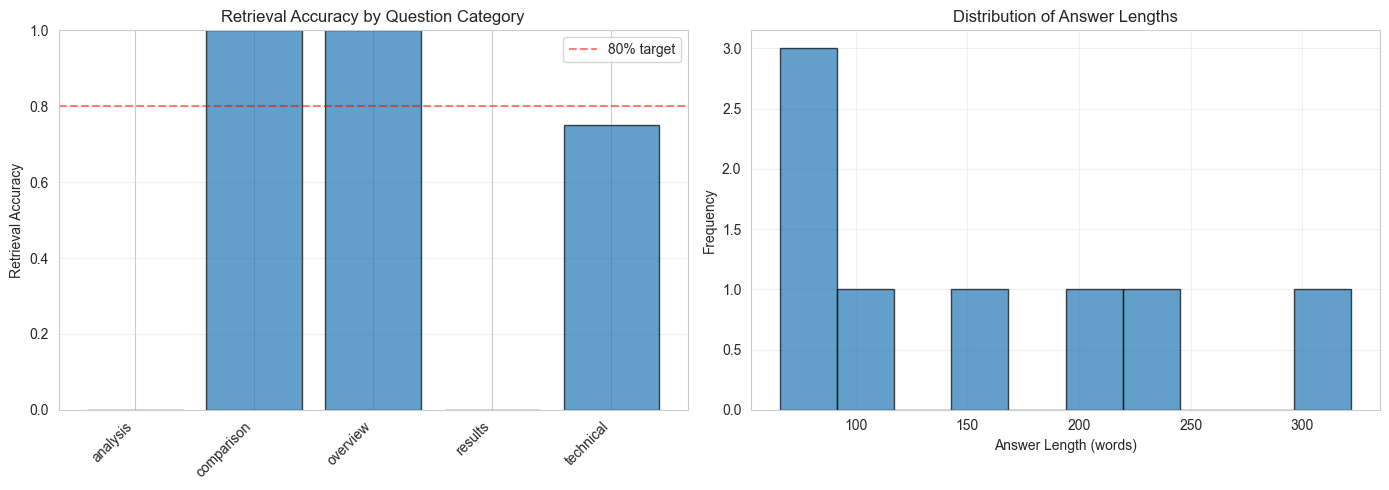

In [ ]:
print("\n Evaluation Results:")
print(f"   Total questions: {len(eval_results)}")
print(f"   Retrieval precision: {eval_results['correct_section'].mean():.1%}")
print(f"   Avg sources per answer: {eval_results['num_sources'].mean():.1f}")
print(f"   Avg answer length: {eval_results['answer_length'].mean():.0f} words")

print("\n Results by Category:")
category_stats = eval_results.groupby('category').agg({
    'correct_section': 'mean',
    'answer_length': 'mean'
}).round(2)
print(category_stats)

# Save results
eval_results.to_csv(f'{Config.RESULTS_PATH}/evaluation_results.csv', index=False)
print(f"\n Saved results to {Config.RESULTS_PATH}/evaluation_results.csv")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retrieval accuracy by category
category_acc = eval_results.groupby('category')['correct_section'].mean()
axes[0].bar(range(len(category_acc)), category_acc.values, edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(category_acc)))
axes[0].set_xticklabels(category_acc.index, rotation=45, ha='right')
axes[0].set_ylabel('Retrieval Accuracy')
axes[0].set_title('Retrieval Accuracy by Question Category')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% target')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Answer length distribution
axes[1].hist(eval_results['answer_length'], bins=10, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Answer Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Answer Lengths')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.RESULTS_PATH}/evaluation_metrics.png', dpi=150, bbox_inches='tight')
print(f"   Saved to {Config.RESULTS_PATH}/evaluation_metrics.png")